In [7]:
import os
import sys
import requests
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report

import yfinance as yf



/home/codespace/.python/current/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [8]:
def grab_price_data():
    tickers_list = ['JPM', 'COST', 'IBM', 'HD', 'ARWR']

# Store multiple result sets.
    end_date = datetime.now().strftime('%Y-%m-%d')
    full_price_history = []

    for ticker in tickers_list:
        price_history = yf.Ticker(ticker).history(period='max', start='2023-06-01', end=end_date, interval='1d')

        for index, row in price_history.iterrows():
            row_data = row.to_dict()
            row_data['symbol'] = ticker
            row_data['datetime'] = index.strftime('%Y-%m-%d')  # Convert Pandas Timestamp to datetime string
            full_price_history.append(row_data)


    price_data = pd.DataFrame(full_price_history)
    price_data.to_csv('price_data.csv', index=False)
    price_data

In [9]:
if os.path.exists('./data/price_data.csv'):
    
    # Load the data
    price_data = pd.read_csv('price_data.csv')

else:

    # Grab the data and store it.
    grab_price_data()

    # Load the data
    price_data = pd.read_csv('price_data.csv')

# Display the head before moving on.
price_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,symbol,datetime
0,133.770797,135.446353,132.722337,134.809448,12248100.0,0.0,0.0,JPM,2023-06-01
1,136.749588,138.630921,136.534017,137.641266,12917200.0,0.0,0.0,JPM,2023-06-02
2,137.288511,137.288511,135.348388,136.289047,8511900.0,0.0,0.0,JPM,2023-06-05
3,135.887284,137.278701,135.426762,136.533997,9329500.0,0.0,0.0,JPM,2023-06-06
4,136.739784,138.425149,136.034282,137.856827,9281400.0,0.0,0.0,JPM,2023-06-07


In [10]:
price_data_ro = price_data

price_data = price_data_ro[['datetime', 'symbol', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']] # rearrange column here
price_data.to_csv('./price_data_ro.csv')

price_data.head()

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-06-01,JPM,133.770797,135.446353,132.722337,134.809448,12248100.0,0.0,0.0
1,2023-06-02,JPM,136.749588,138.630921,136.534017,137.641266,12917200.0,0.0,0.0
2,2023-06-05,JPM,137.288511,137.288511,135.348388,136.289047,8511900.0,0.0,0.0
3,2023-06-06,JPM,135.887284,137.278701,135.426762,136.533997,9329500.0,0.0,0.0
4,2023-06-07,JPM,136.739784,138.425149,136.034282,137.856827,9281400.0,0.0,0.0


In [11]:
price_data.sort_values(by = ['symbol','datetime'], inplace = True)

# calculate the change in price
price_data['change_in_price'] = price_data['Close'].diff()


In [12]:
price_data.head()

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN
705,2023-06-02,ARWR,35.490002,36.070000,34.560001,36.049999,942400.0,0.0,0.0,1.380001
706,2023-06-05,ARWR,35.490002,36.169998,34.970001,35.000000,710300.0,0.0,0.0,-1.049999
707,2023-06-06,ARWR,35.139999,36.341999,34.950001,36.119999,670100.0,0.0,0.0,1.119999
708,2023-06-07,ARWR,36.189999,36.750000,35.380001,36.459999,695500.0,0.0,0.0,0.340000


In [13]:
mask = price_data['symbol'] != price_data['symbol'].shift(1)

# For those rows, let's make the value null
price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

# print the rows that have a null value, should only be 5
price_data[price_data.isna().any(axis = 1)]


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN
176,2023-06-01,COST,495.427089,499.716715,488.394461,498.607819,2407700.0,0.0,0.0,NaN
528,2023-06-01,HD,280.364989,285.467931,276.347812,284.648712,4305100.0,0.0,0.0,NaN
352,2023-06-01,IBM,124.420499,126.076976,123.781150,125.757317,4136100.0,0.0,0.0,NaN
0,2023-06-01,JPM,133.770797,135.446353,132.722337,134.809448,12248100.0,0.0,0.0,NaN


In [15]:
# define the number of days out you want to predict
days_out = 30

# Group by symbol, then apply the rolling function and grab the Min and Max.
price_data_smoothed = price_data.groupby(['symbol'])[['Close','Low','High','Open','Volume']].transform(lambda x: x.ewm(span = days_out).mean())

# Join the smoothed columns with the symbol and datetime column from the old data frame.
smoothed_df = pd.concat([price_data[['symbol','datetime']], price_data_smoothed], axis=1, sort=False)

smoothed_df

,symbol,datetime,Close,Low,High,Open,Volume
704,ARWR,2023-06-01,34.669998,33.250000,35.200001,34.549999,1.026400e+06
705,ARWR,2023-06-02,35.382999,33.926834,35.649500,35.035667,9.830000e+05
706,ARWR,2023-06-05,35.246730,34.297987,35.834690,35.197317,8.859749e+05
707,ARWR,2023-06-06,35.487347,34.477640,35.974472,35.181524,8.264935e+05
708,ARWR,2023-06-07,35.708649,34.682949,36.150924,35.410976,7.966893e+05
...,...,...,...,...,...,...,...
171,JPM,2024-02-06,169.915327,168.428914,170.916366,169.427316,9.726836e+06
172,JPM,2024-02-07,170.271116,168.785762,171.235958,169.831364,9.565458e+06
173,JPM,2024-02-08,170.563305,169.094426,171.498802,170.164827,9.339316e+06
174,JPM,2024-02-09,170.850190,169.389626,171.731139,170.476777,9.142965e+06


In [17]:
days_out = 30

# create a new column that will house the flag, and for each group calculate the diff compared to 30 days ago. Then use Numpy to define the sign.
smoothed_df['Signal_Flag'] = smoothed_df.groupby('symbol')['Close'].transform(lambda x : np.sign(x.diff(days_out)))

# print the first 50 rows
smoothed_df.head(50)

,symbol,datetime,Close,Low,High,Open,Volume,Signal_Flag
704,ARWR,2023-06-01,34.669998,33.250000,35.200001,34.549999,1.026400e+06,NaN
705,ARWR,2023-06-02,35.382999,33.926834,35.649500,35.035667,9.830000e+05,NaN
706,ARWR,2023-06-05,35.246730,34.297987,35.834690,35.197317,8.859749e+05,NaN
707,ARWR,2023-06-06,35.487347,34.477640,35.974472,35.181524,8.264935e+05,NaN
708,ARWR,2023-06-07,35.708649,34.682949,36.150924,35.410976,7.966893e+05,NaN
709,ARWR,2023-06-08,35.706957,34.854531,36.273992,35.600551,7.585232e+05,NaN
710,ARWR,2023-06-09,35.640030,34.893527,36.230063,35.638506,7.123744e+05,NaN
711,ARWR,2023-06-12,35.599457,34.892977,36.159837,35.649661,7.045922e+05,NaN
712,ARWR,2023-06-13,35.549501,34.931149,36.126981,35.629696,6.976744e+05,NaN
713,ARWR,2023-06-14,35.521730,34.908462,36.054476,35.574063,7.323941e+05,NaN


In [18]:
# Calculate the 14 day RSI
n = 14

# First make a copy of the data frame twice
up_df, down_df = price_data[['symbol','change_in_price']].copy(), price_data[['symbol','change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# We need change in price to be absolute.
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
ewma_up = up_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('symbol')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(30)

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN,NaN,NaN,NaN
705,2023-06-02,ARWR,35.490002,36.070000,34.560001,36.049999,942400.0,0.0,0.0,1.380001,0.000000,1.380001,100.000000
706,2023-06-05,ARWR,35.490002,36.169998,34.970001,35.000000,710300.0,0.0,0.0,-1.049999,1.049999,0.000000,53.250260
707,2023-06-06,ARWR,35.139999,36.341999,34.950001,36.119999,670100.0,0.0,0.0,1.119999,0.000000,1.119999,70.324809
708,2023-06-07,ARWR,36.189999,36.750000,35.380001,36.459999,695500.0,0.0,0.0,0.340000,0.000000,0.340000,73.690623
709,2023-06-08,ARWR,36.380001,36.779999,35.560001,35.700001,601600.0,0.0,0.0,-0.759998,0.759998,0.000000,57.012474
710,2023-06-09,ARWR,35.820000,36.020000,35.080002,35.320000,491700.0,0.0,0.0,-0.380001,0.380001,0.000000,50.427915
711,2023-06-12,ARWR,35.709999,35.779999,34.889999,35.380001,662500.0,0.0,0.0,0.060001,0.000000,0.060001,51.449501
712,2023-06-13,ARWR,35.509998,35.930000,35.160000,35.250000,656200.0,0.0,0.0,-0.130001,0.130001,0.000000,48.928720
713,2023-06-14,ARWR,35.209999,35.580002,34.759998,35.340000,959600.0,0.0,0.0,0.090000,0.000000,0.090000,50.852262


In [20]:
# Calculate the Stochastic Oscillator
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','Low']].copy(), price_data[['symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(30)

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
705,2023-06-02,ARWR,35.490002,36.070000,34.560001,36.049999,942400.0,0.0,0.0,1.380001,0.000000,1.380001,100.000000,NaN,NaN,NaN
706,2023-06-05,ARWR,35.490002,36.169998,34.970001,35.000000,710300.0,0.0,0.0,-1.049999,1.049999,0.000000,53.250260,NaN,NaN,NaN
707,2023-06-06,ARWR,35.139999,36.341999,34.950001,36.119999,670100.0,0.0,0.0,1.119999,0.000000,1.119999,70.324809,NaN,NaN,NaN
708,2023-06-07,ARWR,36.189999,36.750000,35.380001,36.459999,695500.0,0.0,0.0,0.340000,0.000000,0.340000,73.690623,NaN,NaN,NaN
709,2023-06-08,ARWR,36.380001,36.779999,35.560001,35.700001,601600.0,0.0,0.0,-0.759998,0.759998,0.000000,57.012474,NaN,NaN,NaN
710,2023-06-09,ARWR,35.820000,36.020000,35.080002,35.320000,491700.0,0.0,0.0,-0.380001,0.380001,0.000000,50.427915,NaN,NaN,NaN
711,2023-06-12,ARWR,35.709999,35.779999,34.889999,35.380001,662500.0,0.0,0.0,0.060001,0.000000,0.060001,51.449501,NaN,NaN,NaN
712,2023-06-13,ARWR,35.509998,35.930000,35.160000,35.250000,656200.0,0.0,0.0,-0.130001,0.130001,0.000000,48.928720,NaN,NaN,NaN
713,2023-06-14,ARWR,35.209999,35.580002,34.759998,35.340000,959600.0,0.0,0.0,0.090000,0.000000,0.090000,50.852262,NaN,NaN,NaN


In [21]:
# Calculate the Williams %R
n = 14

# Make a copy of the high and low column.
low_14, high_14 = price_data[['symbol','Low']].copy(), price_data[['symbol','High']].copy()

# Group by symbol, then apply the rolling function and grab the Min and Max.
low_14 = low_14.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('symbol')['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(30)

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
705,2023-06-02,ARWR,35.490002,36.070000,34.560001,36.049999,942400.0,0.0,0.0,1.380001,0.000000,1.380001,100.000000,NaN,NaN,NaN,NaN
706,2023-06-05,ARWR,35.490002,36.169998,34.970001,35.000000,710300.0,0.0,0.0,-1.049999,1.049999,0.000000,53.250260,NaN,NaN,NaN,NaN
707,2023-06-06,ARWR,35.139999,36.341999,34.950001,36.119999,670100.0,0.0,0.0,1.119999,0.000000,1.119999,70.324809,NaN,NaN,NaN,NaN
708,2023-06-07,ARWR,36.189999,36.750000,35.380001,36.459999,695500.0,0.0,0.0,0.340000,0.000000,0.340000,73.690623,NaN,NaN,NaN,NaN
709,2023-06-08,ARWR,36.380001,36.779999,35.560001,35.700001,601600.0,0.0,0.0,-0.759998,0.759998,0.000000,57.012474,NaN,NaN,NaN,NaN
710,2023-06-09,ARWR,35.820000,36.020000,35.080002,35.320000,491700.0,0.0,0.0,-0.380001,0.380001,0.000000,50.427915,NaN,NaN,NaN,NaN
711,2023-06-12,ARWR,35.709999,35.779999,34.889999,35.380001,662500.0,0.0,0.0,0.060001,0.000000,0.060001,51.449501,NaN,NaN,NaN,NaN
712,2023-06-13,ARWR,35.509998,35.930000,35.160000,35.250000,656200.0,0.0,0.0,-0.130001,0.130001,0.000000,48.928720,NaN,NaN,NaN,NaN
713,2023-06-14,ARWR,35.209999,35.580002,34.759998,35.340000,959600.0,0.0,0.0,0.090000,0.000000,0.090000,50.852262,NaN,NaN,NaN,NaN


In [23]:
# Calculate the MACD
ema_26 = price_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean()

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd

# Print the head.
price_data.head(30)

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
705,2023-06-02,ARWR,35.490002,36.070000,34.560001,36.049999,942400.0,0.0,0.0,1.380001,0.000000,1.380001,100.000000,NaN,NaN,NaN,NaN,0.030962,0.017201
706,2023-06-05,ARWR,35.490002,36.169998,34.970001,35.000000,710300.0,0.0,0.0,-1.049999,1.049999,0.000000,53.250260,NaN,NaN,NaN,NaN,0.006891,0.012975
707,2023-06-06,ARWR,35.139999,36.341999,34.950001,36.119999,670100.0,0.0,0.0,1.119999,0.000000,1.119999,70.324809,NaN,NaN,NaN,NaN,0.036211,0.020847
708,2023-06-07,ARWR,36.189999,36.750000,35.380001,36.459999,695500.0,0.0,0.0,0.340000,0.000000,0.340000,73.690623,NaN,NaN,NaN,NaN,0.064910,0.033955
709,2023-06-08,ARWR,36.380001,36.779999,35.560001,35.700001,601600.0,0.0,0.0,-0.759998,0.759998,0.000000,57.012474,NaN,NaN,NaN,NaN,0.048445,0.037882
710,2023-06-09,ARWR,35.820000,36.020000,35.080002,35.320000,491700.0,0.0,0.0,-0.380001,0.380001,0.000000,50.427915,NaN,NaN,NaN,NaN,0.019836,0.033315
711,2023-06-12,ARWR,35.709999,35.779999,34.889999,35.380001,662500.0,0.0,0.0,0.060001,0.000000,0.060001,51.449501,NaN,NaN,NaN,NaN,0.003187,0.026075
712,2023-06-13,ARWR,35.509998,35.930000,35.160000,35.250000,656200.0,0.0,0.0,-0.130001,0.130001,0.000000,48.928720,NaN,NaN,NaN,NaN,-0.014840,0.016623
713,2023-06-14,ARWR,35.209999,35.580002,34.759998,35.340000,959600.0,0.0,0.0,0.090000,0.000000,0.090000,50.852262,NaN,NaN,NaN,NaN,-0.022776,0.007796


In [25]:
# Calculate the Price Rate of Change
n = 9

# Calculate the Rate of Change in the Price, and store it in the Data Frame.
price_data['Price_Rate_Of_Change'] = price_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(30)

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
705,2023-06-02,ARWR,35.490002,36.070000,34.560001,36.049999,942400.0,0.0,0.0,1.380001,0.000000,1.380001,100.000000,NaN,NaN,NaN,NaN,0.030962,0.017201,NaN
706,2023-06-05,ARWR,35.490002,36.169998,34.970001,35.000000,710300.0,0.0,0.0,-1.049999,1.049999,0.000000,53.250260,NaN,NaN,NaN,NaN,0.006891,0.012975,NaN
707,2023-06-06,ARWR,35.139999,36.341999,34.950001,36.119999,670100.0,0.0,0.0,1.119999,0.000000,1.119999,70.324809,NaN,NaN,NaN,NaN,0.036211,0.020847,NaN
708,2023-06-07,ARWR,36.189999,36.750000,35.380001,36.459999,695500.0,0.0,0.0,0.340000,0.000000,0.340000,73.690623,NaN,NaN,NaN,NaN,0.064910,0.033955,NaN
709,2023-06-08,ARWR,36.380001,36.779999,35.560001,35.700001,601600.0,0.0,0.0,-0.759998,0.759998,0.000000,57.012474,NaN,NaN,NaN,NaN,0.048445,0.037882,NaN
710,2023-06-09,ARWR,35.820000,36.020000,35.080002,35.320000,491700.0,0.0,0.0,-0.380001,0.380001,0.000000,50.427915,NaN,NaN,NaN,NaN,0.019836,0.033315,NaN
711,2023-06-12,ARWR,35.709999,35.779999,34.889999,35.380001,662500.0,0.0,0.0,0.060001,0.000000,0.060001,51.449501,NaN,NaN,NaN,NaN,0.003187,0.026075,NaN
712,2023-06-13,ARWR,35.509998,35.930000,35.160000,35.250000,656200.0,0.0,0.0,-0.130001,0.130001,0.000000,48.928720,NaN,NaN,NaN,NaN,-0.014840,0.016623,NaN
713,2023-06-14,ARWR,35.209999,35.580002,34.759998,35.340000,959600.0,0.0,0.0,0.090000,0.000000,0.090000,50.852262,NaN,NaN,NaN,NaN,-0.022776,0.007796,0.019325


In [26]:
def obv(group):
    
    # Grab the volume and close column.
    volume = group['Volume']
    change = group['Close'].diff()

    # intialize the previous OBV
    prev_obv = 0
    obv_values = []

    # calculate the On Balance Volume
    for i, j in zip(change, volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        # OBV.append(current_OBV)
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Return a panda series.
    return pd.Series(obv_values, index = group.index)
        

# apply the function to each group
obv_groups = price_data.groupby('symbol').apply(obv)

# add to the data frame, but drop the old index, before adding it.
price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

# display the data frame.
price_data.head(30)

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,...,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0
705,2023-06-02,ARWR,35.490002,36.070000,34.560001,36.049999,942400.0,0.0,0.0,1.380001,...,1.380001,100.000000,NaN,NaN,NaN,NaN,0.030962,0.017201,NaN,942400.0
706,2023-06-05,ARWR,35.490002,36.169998,34.970001,35.000000,710300.0,0.0,0.0,-1.049999,...,0.000000,53.250260,NaN,NaN,NaN,NaN,0.006891,0.012975,NaN,232100.0
707,2023-06-06,ARWR,35.139999,36.341999,34.950001,36.119999,670100.0,0.0,0.0,1.119999,...,1.119999,70.324809,NaN,NaN,NaN,NaN,0.036211,0.020847,NaN,902200.0
708,2023-06-07,ARWR,36.189999,36.750000,35.380001,36.459999,695500.0,0.0,0.0,0.340000,...,0.340000,73.690623,NaN,NaN,NaN,NaN,0.064910,0.033955,NaN,1597700.0
709,2023-06-08,ARWR,36.380001,36.779999,35.560001,35.700001,601600.0,0.0,0.0,-0.759998,...,0.000000,57.012474,NaN,NaN,NaN,NaN,0.048445,0.037882,NaN,996100.0
710,2023-06-09,ARWR,35.820000,36.020000,35.080002,35.320000,491700.0,0.0,0.0,-0.380001,...,0.000000,50.427915,NaN,NaN,NaN,NaN,0.019836,0.033315,NaN,504400.0
711,2023-06-12,ARWR,35.709999,35.779999,34.889999,35.380001,662500.0,0.0,0.0,0.060001,...,0.060001,51.449501,NaN,NaN,NaN,NaN,0.003187,0.026075,NaN,1166900.0
712,2023-06-13,ARWR,35.509998,35.930000,35.160000,35.250000,656200.0,0.0,0.0,-0.130001,...,0.000000,48.928720,NaN,NaN,NaN,NaN,-0.014840,0.016623,NaN,510700.0
713,2023-06-14,ARWR,35.209999,35.580002,34.759998,35.340000,959600.0,0.0,0.0,0.090000,...,0.090000,50.852262,NaN,NaN,NaN,NaN,-0.022776,0.007796,0.019325,1470300.0


In [27]:
# Create a column we wish to predict
'''
    In this case, let's create an output column that will be 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise.
    In other words, if the today's closing price is greater than yesterday's closing price it would be 1.
'''

# Group by the `Symbol` column, then grab the `Close` column.
close_groups = price_data.groupby('symbol')['Close']

# Apply the lambda function which will return -1.0 for down, 1.0 for up and 0.0 for no change.
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe.
price_data['Prediction'] = close_groups

# for simplicity in later sections I'm going to make a change to our prediction column. To keep this as a binary classifier I'll change flat days and consider them up days.
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(50)

# OPTIONAL CODE: Dump the data frame to a CSV file to examine the data yourself.
# price_data.to_csv('final_metrics.csv')

,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,...,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
704,2023-06-01,ARWR,34.549999,35.200001,33.250000,34.669998,1026400.0,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,0.0,NaN
705,2023-06-02,ARWR,35.490002,36.070000,34.560001,36.049999,942400.0,0.0,0.0,1.380001,...,100.000000,NaN,NaN,NaN,NaN,0.030962,0.017201,NaN,942400.0,1.0
706,2023-06-05,ARWR,35.490002,36.169998,34.970001,35.000000,710300.0,0.0,0.0,-1.049999,...,53.250260,NaN,NaN,NaN,NaN,0.006891,0.012975,NaN,232100.0,-1.0
707,2023-06-06,ARWR,35.139999,36.341999,34.950001,36.119999,670100.0,0.0,0.0,1.119999,...,70.324809,NaN,NaN,NaN,NaN,0.036211,0.020847,NaN,902200.0,1.0
708,2023-06-07,ARWR,36.189999,36.750000,35.380001,36.459999,695500.0,0.0,0.0,0.340000,...,73.690623,NaN,NaN,NaN,NaN,0.064910,0.033955,NaN,1597700.0,1.0
709,2023-06-08,ARWR,36.380001,36.779999,35.560001,35.700001,601600.0,0.0,0.0,-0.759998,...,57.012474,NaN,NaN,NaN,NaN,0.048445,0.037882,NaN,996100.0,-1.0
710,2023-06-09,ARWR,35.820000,36.020000,35.080002,35.320000,491700.0,0.0,0.0,-0.380001,...,50.427915,NaN,NaN,NaN,NaN,0.019836,0.033315,NaN,504400.0,-1.0
711,2023-06-12,ARWR,35.709999,35.779999,34.889999,35.380001,662500.0,0.0,0.0,0.060001,...,51.449501,NaN,NaN,NaN,NaN,0.003187,0.026075,NaN,1166900.0,1.0
712,2023-06-13,ARWR,35.509998,35.930000,35.160000,35.250000,656200.0,0.0,0.0,-0.130001,...,48.928720,NaN,NaN,NaN,NaN,-0.014840,0.016623,NaN,510700.0,-1.0
713,2023-06-14,ARWR,35.209999,35.580002,34.759998,35.340000,959600.0,0.0,0.0,0.090000,...,50.852262,NaN,NaN,NaN,NaN,-0.022776,0.007796,0.019325,1470300.0,1.0


In [28]:
print('Before NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('After NaN Drop we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.head()

Before NaN Drop we have 880 rows and 22 columns
After NaN Drop we have 815 rows and 22 columns


,datetime,symbol,Open,High,Low,Close,Volume,Dividends,Stock Splits,change_in_price,...,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Prediction
717,2023-06-21,ARWR,35.480000,35.900002,34.834999,35.529999,775900.0,0.0,0.0,-0.240002,...,52.240652,33.250000,36.779999,64.589223,-35.410777,0.000132,0.000780,-0.025507,129300.0,-1.0
718,2023-06-22,ARWR,35.580002,35.959999,35.000000,35.549999,476500.0,0.0,0.0,0.020000,...,52.690952,34.529999,36.779999,45.333354,-54.666646,-0.000193,0.000578,-0.004202,605800.0,1.0
719,2023-06-23,ARWR,35.209999,35.720001,34.950001,35.240002,992000.0,0.0,0.0,-0.309998,...,45.088176,34.529999,36.779999,31.555684,-68.444316,-0.019239,-0.003500,-0.002265,-386200.0,-1.0
720,2023-06-26,ARWR,35.150002,35.419998,34.910000,35.180000,634500.0,0.0,0.0,-0.060001,...,43.680588,34.529999,36.779999,28.888957,-71.111043,-0.037238,-0.010403,-0.005653,-1020700.0,-1.0
721,2023-06-27,ARWR,35.500000,36.490002,34.820000,36.080002,1307100.0,0.0,0.0,0.900002,...,63.436306,34.529999,36.779999,68.889025,-31.110975,0.006180,-0.007026,0.023546,286400.0,1.0


In [29]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

In [30]:
# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  67.15686274509804


In [31]:
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.648936,0.642105,0.645503,95.000000
Up Day,0.690909,0.697248,0.694064,109.000000
accuracy,0.671569,0.671569,0.671569,0.671569
macro avg,0.669923,0.669676,0.669783,204.000000
weighted avg,0.671363,0.671569,0.671450,204.000000


In [38]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Percision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))

disp = ConfusionMatrixDisplay(rand_frst_clf, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize= 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

Accuracy: 0.6715686274509803
Percision: 0.6909090909090909
Recall: 0.6972477064220184
Specificity: 0.6421052631578947


TypeError: ConfusionMatrixDisplay.__init__() got an unexpected keyword argument 'normalize'

In [39]:
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

k_percent               0.199971
r_percent               0.199859
RSI                     0.187337
Price_Rate_Of_Change    0.154096
MACD                    0.138143
On Balance Volume       0.120595
dtype: float64

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

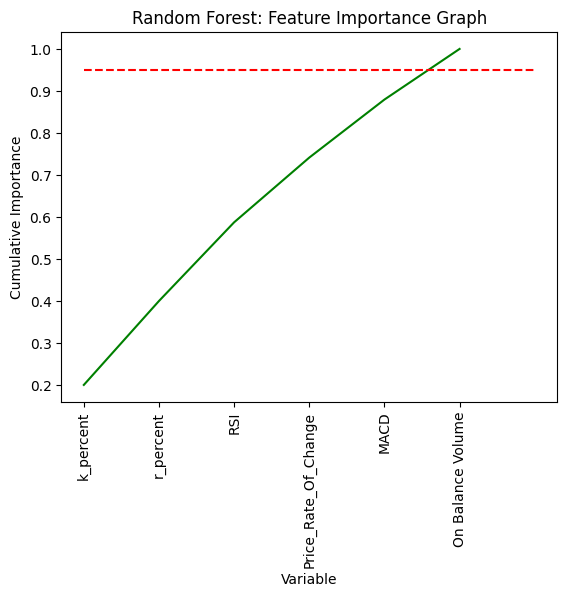

In [40]:
# store the values in a list to plot.
x_values = list(range(len(rand_frst_clf.feature_importances_)))

# Cumulative importances
cumulative_importances = np.cumsum(feature_imp.values)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

In [42]:
rfc_disp = RocCurveDisplay(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

TypeError: RocCurveDisplay.__init__() got an unexpected keyword argument 'alpha'

In [43]:
rfc_disp = RocCurveDisplay(rand_frst_clf, X_test, y_test, alpha = 0.8)
plt.show()

TypeError: RocCurveDisplay.__init__() got an unexpected keyword argument 'alpha'

In [44]:
print('Random Forest Out-Of-Bag Error Score: {}'.format(rand_frst_clf.oob_score_))

Random Forest Out-Of-Bag Error Score: 0.7004909983633388


In [45]:
# Number of trees in random forest
# Number of trees is not a parameter that should be tuned, but just set large enough usually. There is no risk of overfitting in random forest with growing number of # trees, as they are trained independently from each other. 
n_estimators = list(range(200, 2000, 200))

# Number of features to consider at every split
max_features = ['auto', 'sqrt', None, 'log2']

# Maximum number of levels in tree
# Max depth is a parameter that most of the times should be set as high as possible, but possibly better performance can be achieved by setting it lower.
max_depth = list(range(10, 110, 10))
max_depth.append(None)

# Minimum number of samples required to split a node
# Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree. Too high values can also lead to # under-fitting hence depending on the level of underfitting or overfitting, you can tune the values for min_samples_split.
min_samples_split = [2, 5, 10, 20, 30, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 7, 12, 14, 16 ,20]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800], 'max_features': ['auto', 'sqrt', None, 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10, 20, 30, 40], 'min_samples_leaf': [1, 2, 7, 12, 14, 16, 20], 'bootstrap': [True, False]}


In [46]:
# New Random Forest Classifier to house optimal parameters
rf = RandomForestClassifier()

# Specfiy the details of our Randomized Search
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=16, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, max_features=None, min_samples_leaf=2, min_samples_split=40, n_estimators=1200; total time=   3.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=14, min_samples_split=2, n_e

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:542: FitFailedWarning: 
75 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 1344, in wrapper
    estimator._validate_params()
  File "/home/codespace/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt', None,
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 7, 12, 14,
                                                             16, 20],
                                        'min_samples_split': [2, 5, 10, 20, 30,
                                                              40],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800]},
                   random_state=42, verbose=2)

In [47]:
# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)# With the new Random Classifier trained we can proceed to our regular steps, prediction.
rf_random.predict(X_test)


'''
    ACCURACY
'''
# Once the predictions have been made, then grab the accuracy score.
print('Correct Prediction (%): ', accuracy_score(y_test, rf_random.predict(X_test), normalize = True) * 100.0)


'''
    CLASSIFICATION REPORT
'''
# Define the traget names
target_names = ['Down Day', 'Up Day']

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose()
display(report_df)
print('\n')

'''
    FEATURE IMPORTANCE
'''
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(rand_frst_clf.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
display(feature_imp)

Correct Prediction (%):  69.11764705882352


,precision,recall,f1-score,support
Down Day,0.648936,0.642105,0.645503,95.000000
Up Day,0.690909,0.697248,0.694064,109.000000
accuracy,0.671569,0.671569,0.671569,0.671569
macro avg,0.669923,0.669676,0.669783,204.000000
weighted avg,0.671363,0.671569,0.671450,204.000000


k_percent               0.199971
r_percent               0.199859
RSI                     0.187337
Price_Rate_Of_Change    0.154096
MACD                    0.138143
On Balance Volume       0.120595
dtype: float64

Correct Prediction (%):  69.11764705882352


,precision,recall,f1-score,support
Down Day,0.648936,0.642105,0.645503,95.000000
Up Day,0.690909,0.697248,0.694064,109.000000
accuracy,0.671569,0.671569,0.671569,0.671569
macro avg,0.669923,0.669676,0.669783,204.000000
weighted avg,0.671363,0.671569,0.671450,204.000000


k_percent               0.199971
r_percent               0.199859
RSI                     0.187337
Price_Rate_Of_Change    0.154096
MACD                    0.138143
On Balance Volume       0.120595
dtype: float64

TypeError: RocCurveDisplay.__init__() got an unexpected keyword argument 'alpha'

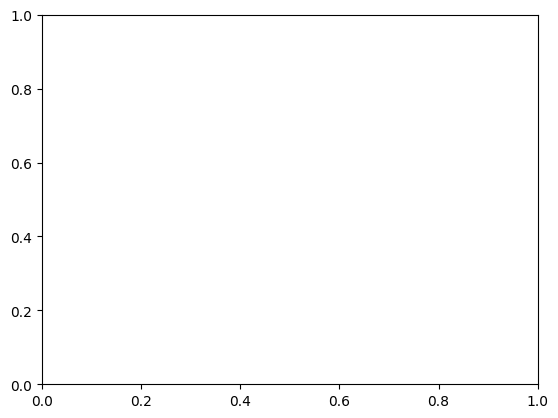

In [48]:
'''
    ROC CURVE
'''

fig, ax = plt.subplots()

# Create an ROC Curve plot.
rfc_disp = RocCurveDisplay(rand_frst_clf, X_test, y_test, alpha = 0.8, name='ROC Curve', lw=1, ax=ax)

# Add our Chance Line
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Make it look pretty.
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="ROC Curve Random Forest")

# Add the legend to the plot
ax.legend(loc="lower right")

plt.show()